In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

from utils.new_or_used import build_dataset
from utils.funcs import transform_x, show_evaluation

warnings.filterwarnings('ignore')
%matplotlib inline

### 1. Leer los datos

Se utilizó la función predefinada en el ejercicio: `build_dataset` para dividir los datos en entrenamiento y prueba.

In [2]:
X_train_org, y_train_org, X_test_org, y_test_org = build_dataset()

### 2. Transformar los datos

> *Nota:* Todas las transformaciones se empaquetaron en la función `transform_x` dentro del archivo `utils.func.py`.

1. Se reorganizó la estructura de los datos originales, los cuales tenían una estructura de json anidados. 
2. Se eliminaron las variables que no eran relevantes para el problema.
3. Se crearon nuevas variables como algunas categóricas a partir de continuas como el número de productos en stock o número de productos vendidos. 

In [3]:
# La variable objetivo toma el valor de 1 si es nuevo y 0 si es usado
y_train = [1 if x == 'new' else 0 for x in y_train_org]
y_test = [1 if x == 'new' else 0 for x in y_test_org]

# Crear dataframe X_train and X_test
X_train_df = pd.DataFrame(X_train_org)
X_test_df = pd.DataFrame(X_test_org)

# Limpiar y transformar dataframes
X_train_df = transform_x(X_train_df)
X_test_df = transform_x(X_test_df)

# Se incluye la variable objetivo en X_train para data analysis
X_train_df["target"] = y_train

X_train_df.head(5)


,warranty,sub_status,condition,seller_id,listing_type_id,price,buying_mode,category_id,last_updated,pictures,...,number_variations,has_attributes,number_attributes,has_warranty,sold_quantity_category,available_quantity_category,time_diff,days_active,days_active_category,target
0,Nada,none,new,8208882349,bronze,80.0,buy_it_now,MLA126406,2015-09-05T20:42:58.000Z,"[{'size': '500x375', 'secure_url': 'https://a2...",...,0,0,0,1,0,0,5.18400,0,0. 0,1
1,NUESTRA REPUTACION,none,used,8141699488,silver,2650.0,buy_it_now,MLA10267,2015-09-26T18:08:34.000Z,"[{'size': '499x334', 'secure_url': 'https://a2...",...,0,0,0,1,0,0,5.18400,0,0. 0,0
2,Nada,none,used,8386096505,bronze,60.0,buy_it_now,MLA1227,2015-09-09T23:57:10.000Z,"[{'size': '375x500', 'secure_url': 'https://a2...",...,0,0,0,1,0,0,5.18400,0,0. 0,0
3,Nada,none,new,5377752182,silver,580.0,buy_it_now,MLA86345,2015-10-05T16:03:50.306Z,"[{'size': '441x423', 'secure_url': 'https://a2...",...,0,0,0,1,0,0,5.72552,6,1. 1-7,1
4,MI REPUTACION.,none,used,2938071313,bronze,30.0,buy_it_now,MLA41287,2015-08-28T13:37:41.000Z,"[{'size': '375x500', 'secure_url': 'https://a2...",...,0,0,0,1,0,0,5.18400,3,1. 1-7,0


In [4]:
X_train_df.columns

Index(['warranty', 'sub_status', 'condition', 'seller_id', 'listing_type_id',
       'price', 'buying_mode', 'category_id', 'last_updated', 'pictures', 'id',
       'accepts_mercadopago', 'currency_id', 'title', 'automatic_relist',
       'date_created', 'stop_time', 'status', 'initial_quantity', 'start_time',
       'sold_quantity', 'available_quantity', 'seller_country', 'seller_state',
       'seller_city', 'shipping_local_pick_up', 'shipping_tags',
       'shipping_free_shipping', 'shipping_mode', 'nmp_payment_visa_electron',
       'nmp_payment_visa', 'nmp_payment_mastercard', 'nmp_payment_mercadopago',
       'nmp_payment_tarjeta_de_crédito', 'nmp_payment_mastercard_maestro',
       'nmp_payment_contra_reembolso', 'nmp_payment_transferencia_bancaria',
       'nmp_payment_acordar_con_el_comprador', 'nmp_payment_american_express',
       'nmp_payment_cheque_certificado', 'nmp_payment_giro_postal',
       'nmp_payment_diners', 'nmp_payment_efectivo',
       'tag_good_quality_thumbna

### 3. Modelos

#### 3.1. Modelo base logit
Modelo simple de baseline sin optimización de hiper-parámetros, ni selección de features.

> Solo con estas carateristicas da el mínimo esperado de accuracy: `0.8611` y un ROC AUC de `0.9338`

Los siguientes pasos serán mejorar el modelo baseline y probar otros modelos.

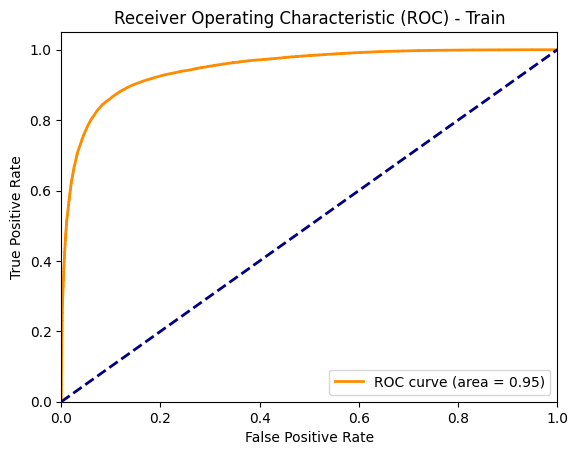

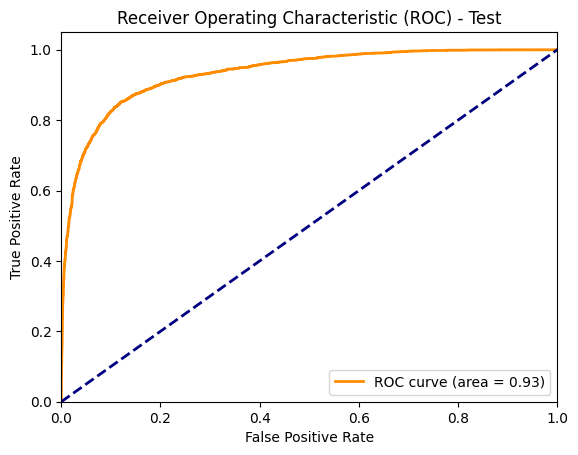

Evaluation using accuracy:
Accuracy train: 0.8799
Accuracy validation: 0.8605
Accuracy test: 0.8611

Evaluation using ROC AUC:
ROC AUC train: 0.9478
ROC AUC validation: 0.9340
ROC AUC test: 0.9338

Reporte de clasificacion del conjunto test:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      4594
           1       0.87      0.88      0.87      5406

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('txt',
                                                  TfidfVectorizer(max_features=10000),
                                                  'title'),
                                                 ('cat', OneHotEncoder(),
                                                  ['sold_quantity_category',
                                                   'listing_type_id']),
                                                 ('num', StandardScaler(),
                                                  ['price', 'days_active'])])),
                ('classifier', LogisticRegression())])

In [9]:
# Lista de variables de interes de acuerdo al EDA
features_list = ['title', 'price', 'sold_quantity_category', 'listing_type_id', 'days_active']

# Seleccionar variables de interés
X_train = X_train_df[features_list]
X_test = X_test_df[features_list]

modelo = LogisticRegression()

# Preprocesamiento de datos
# TfidfVectorizer para textos
# OneHotEncoder para las categoricas
# StandardScaler para las variables continuas
preprocessor = ColumnTransformer(
    transformers=[
        ('txt', TfidfVectorizer(max_features=10000), 'title'),
        ('cat', OneHotEncoder(), ['sold_quantity_category', 'listing_type_id']),
        ('num', StandardScaler(), ['price', 'days_active'])
    ])

# Crear el pipeline con el preprocesador y el modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])


pipeline = show_evaluation(X_train, y_train, X_test, y_test, pipeline, show_test=True)

pipeline

#### 3.2. Modelo base logit mejorado

1. Se fueron incluyendo las variables una a una dependiendo de la intuición del EDA para ver como mejoraban la clasificacion. Hasta obtener el mejor set de variables.
2. Se hizo optimización de hiperparamtros para mejorar la estimacón anterior entoncontrada en el punto 1.
3. Despues de todo esto se alcanzó un **Accuracy** de `0.8879` y un **ROC AUC** de `0.9524`. Mejorando asi el clasificador base.

Best parameters found:  {'classifier__C': 1}
Best cross-validation score (ROC AUC):  0.9517632561709641



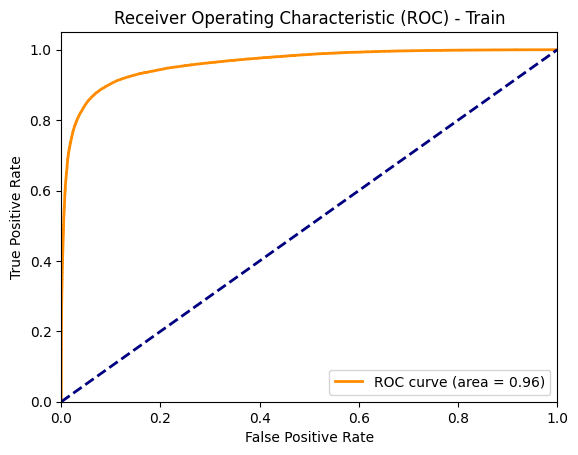

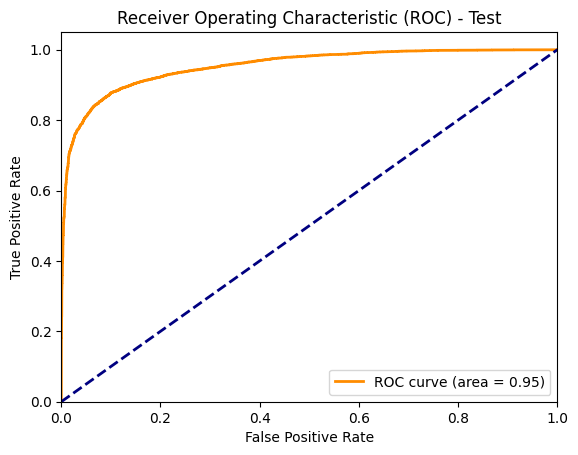

Evaluation using accuracy:
Accuracy train: 0.9022
Accuracy validation: 0.8874
Accuracy test: 0.8879

Evaluation using ROC AUC:
ROC AUC train: 0.9616
ROC AUC validation: 0.9518
ROC AUC test: 0.9524

Reporte de clasificacion del conjunto test:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      4594
           1       0.91      0.88      0.89      5406

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('titulo',
                                                  TfidfVectorizer(max_features=10000),
                                                  'title'),
                                                 ('garantia',
                                                  TfidfVectorizer(max_features=10000),
                                                  'warranty'),
                                                 ('cat', OneHotEncoder(),
                                                  ['sold_quantity_category',
                                                   'listing_type_id',
                                                   'buying_mode',
                                                   'shipping_mode',
                                                   'available_quantity_category',
                                                   'shipping_local_pick_up',
                                                   'shipping_free_shipping',
                                                   'has_variations']),
                                                 ('num', StandardScaler(),
                                                  ['price', 'days_active'])])),
                ('classifier', LogisticRegression(C=1, n_jobs=-1))])

In [5]:
# Lista de variables de interes de acuerdo al EDA
features_list = ['title', 'price', 'sold_quantity_category', 'listing_type_id', 
                 'days_active', 'buying_mode', 'available_quantity_category', 
                 'shipping_local_pick_up', 'shipping_free_shipping', 'shipping_mode',
                 'has_variations', 'warranty']

# Seleccionar variables de interés
X_train = X_train_df[features_list]
X_test = X_test_df[features_list]

# Preprocesamiento de datos
# TfidfVectorizer para textos
# OneHotEncoder para las categoricas
# StandardScaler para las variables continuas
preprocessor = ColumnTransformer(
    transformers=[
        ('titulo', TfidfVectorizer(max_features=10000), 'title'),
        ('garantia', TfidfVectorizer(max_features=10000), 'warranty'),
        ('cat', OneHotEncoder(), ['sold_quantity_category', 'listing_type_id', 'buying_mode', 'shipping_mode',
                                  'available_quantity_category', 'shipping_local_pick_up', 'shipping_free_shipping',
                                  'has_variations']),
        ('num', StandardScaler(), ['price', 'days_active'])
    ])

# Crear el pipeline con el preprocesador y el modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(n_jobs=-1))
])

# Definir la rejilla de parámetros para la búsqueda
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    # 'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    # 'classifier__penalty': ['l2', 'none'],  # 'liblinear' y 'saga' soportan 'l1'
    # 'classifier__tol': [1e-4, 1e-3, 1e-2]
}

# Crear el GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')

# Entrenar el modelo con búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros y el mejor puntaje
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score (ROC AUC): ", grid_search.best_score_)
print("")

pipeline = show_evaluation(X_train, y_train, X_test, y_test, grid_search.best_estimator_, show_test=True)

# Guardar el modelo en la varpeta models
joblib.dump(pipeline, '../models/logit/logit_model_trained.pkl')

pipeline

In [13]:
# Usar el modelo guardado
modelo_cargado = joblib.load('../models/logit/logit_model_trained.pkl')
modelo_cargado.predict(X_test)

array([0, 1, 1, ..., 0, 0, 0])

#### 3.2 XGBoost

Best parameters found:  {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 150}
Best cross-validation score (ROC AUC):  0.9526687193244676



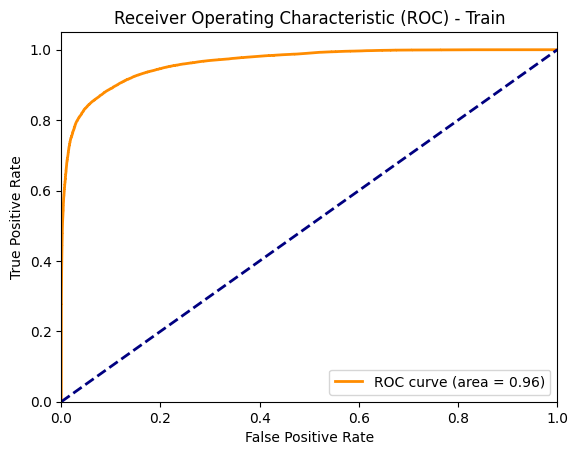

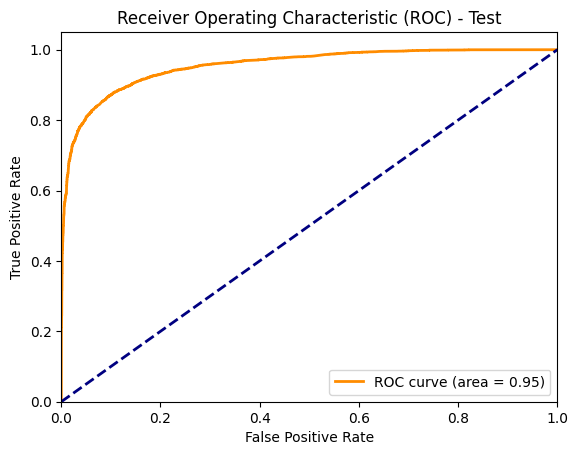

Evaluation using accuracy:
Accuracy train: 0.8942
Accuracy validation: 0.8807
Accuracy test: 0.8854

Evaluation using ROC AUC:
ROC AUC train: 0.9635
ROC AUC validation: 0.9527
ROC AUC test: 0.9541

Reporte de clasificacion del conjunto test:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      4594
           1       0.91      0.88      0.89      5406

    accuracy                           0.89     10000
   macro avg       0.88      0.89      0.88     10000
weighted avg       0.89      0.89      0.89     10000



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('titulo',
                                                  TfidfVectorizer(max_features=10000),
                                                  'title'),
                                                 ('garantia',
                                                  TfidfVectorizer(max_features=10000),
                                                  'warranty'),
                                                 ('cat', OneHotEncoder(),
                                                  ['sold_quantity_category',
                                                   'listing_type_id',
                                                   'buying_mode',
                                                   'shipping_mode',
                                                   'available_quantity_category',
                                                   'shipping_local_pick_up',
                                                   'shipping_free_ship...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=150, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [4]:

# Lista de variables de interes de acuerdo al EDA
features_list = ['title', 'price', 'sold_quantity_category', 'listing_type_id', 
                 'days_active', 'buying_mode', 'available_quantity_category', 
                 'shipping_local_pick_up', 'shipping_free_shipping', 'shipping_mode',
                 'has_variations', 'warranty']

# Seleccionar variables de interés
X_train = X_train_df[features_list]
X_test = X_test_df[features_list]


# Definir el modelo XGBoost
model = XGBClassifier()

# Preprocesamiento de datos
# TfidfVectorizer para textos
# OneHotEncoder para las categoricas
# StandardScaler para las variables continuas
preprocessor = ColumnTransformer(
    transformers=[
        ('titulo', TfidfVectorizer(max_features=10000), 'title'),
        ('garantia', TfidfVectorizer(max_features=10000), 'warranty'),
        ('cat', OneHotEncoder(), ['sold_quantity_category', 'listing_type_id', 'buying_mode', 'shipping_mode',
                                  'available_quantity_category', 'shipping_local_pick_up', 'shipping_free_shipping',
                                  'has_variations']),
        ('num', StandardScaler(), ['price', 'days_active'])
    ])

# Crear el pipeline con el preprocesador y el modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Definir la rejilla de parámetros para la búsqueda
param_grid = {
    'classifier__n_estimators': [50, 100, 150],           # Number of boosting rounds
    'classifier__learning_rate': [0.01, 0.1, 0.2],        # Step size shrinkage used in update to prevent overfitting
    'classifier__max_depth': [3, 5, 7],                  # Maximum depth of a tree
    # 'classifier__subsample': [0.6, 0.8, 1.0],             # Subsample ratio of the training instances
    # 'classifier__colsample_bytree': [0.6, 0.8, 1.0],      # Subsample ratio of columns when constructing each tree
    # 'classifier__gamma': [0, 0.1, 0.2],                   # Minimum loss reduction required to make a further partition on a leaf node of the tree
    # 'classifier__reg_alpha': [0, 0.5, 1],                 # L1 regularization term on weights
    # 'classifier__reg_lambda': [0, 0.5, 1]                 # L2 regularization term on weights
}

# # Crear el GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')

# Entrenar el modelo con búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros y el mejor puntaje
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score (ROC AUC): ", grid_search.best_score_)
print("")

pipeline = show_evaluation(X_train, y_train, X_test, y_test, grid_search.best_estimator_, show_test=True)
# pipeline = show_evaluation(X_train, y_train, X_test, y_test, pipeline, show_test=True)

pipeline

#### Otros modelos (no tan existosos)

### Support Vector Classifier (SVC)

In [4]:
from sklearn.svm import SVC

# Lista de variables de interes de acuerdo al EDA
features_list = ['title', 'price', 'sold_quantity_category', 'listing_type_id', 
                 'days_active', 'buying_mode', 'available_quantity_category', 
                 'shipping_local_pick_up', 'shipping_free_shipping', 'shipping_mode',
                 'has_variations', 'warranty']


# Seleccionar variables de interés
X_train = X_train_df[features_list]
X_test = X_test_df[features_list]

# Definir el modelo XGBoost
model = SVC(probability=True, random_state = 42)

# Preprocesamiento de datos
# TfidfVectorizer para textos
# OneHotEncoder para las categoricas
# StandardScaler para las variables continuas
preprocessor = ColumnTransformer(
    transformers=[
        ('titulo', TfidfVectorizer(max_features=10000), 'title'),
        ('garantia', TfidfVectorizer(max_features=10000), 'warranty'),
        ('cat', OneHotEncoder(), ['sold_quantity_category', 'listing_type_id', 'buying_mode', 'shipping_mode',
                                  'available_quantity_category', 'shipping_local_pick_up', 'shipping_free_shipping',
                                  'has_variations']),
        ('num', StandardScaler(), ['price', 'days_active'])
    ])

# Crear el pipeline con el preprocesador y el modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Definir la rejilla de parámetros para la búsqueda
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    # 'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    # 'classifier__gamma': ['scale', 'auto'],
    # 'classifier__degree': [2, 3, 4],  # Solo relevante para el kernel 'poly'
    # 'classifier__coef0': [0.0, 0.1, 0.5, 1.0]  # Relevante para 'poly' y 'sigmoid'
}

# Crear el GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')

# Entrenar el modelo con búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros y el mejor puntaje
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score (ROC AUC): ", grid_search.best_score_)
print("")

n = 1000 # 9000 en 5.3 minutos   - 1000 en 7 segundos
pipeline = show_evaluation(X_train[:n], y_train[:n], y_test, grid_search.best_estimator_, show_test=True)
# pipeline = show_evaluation(X_train[:n], y_train[:n], X_test, y_test, pipeline, show_test=True)

pipeline

#### 3.3. Neural Networks

Puede ayudar dada la alta dimensionalidad del problema.

In [80]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import FeatureSpace

# Validar el numero de GPUs disponibles para reducir el tiempo del procesamiento
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

def dataframe_to_dataset(dataframe, labels):
    dataframe = dataframe.copy()
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

features_list = ['price', 'days_active', 'sold_quantity_category', 'listing_type_id', 
                 'buying_mode', 'shipping_mode', 'available_quantity_category', 
                 'shipping_local_pick_up', 'shipping_free_shipping', 'has_variations']

# Dividir el conjunto de datos en entrenamiento y validación
X_train_df, X_val_df, y_train, y_val = train_test_split(X_train_df, y_train, test_size=0.2, random_state=1337)


X_train = X_train_df[features_list]
X_val = X_val_df[features_list]
X_test = X_test_df[features_list]

X_train_ds = dataframe_to_dataset(X_train, y_train)
X_val_ds = dataframe_to_dataset(X_val, y_val)
X_test_ds = dataframe_to_dataset(X_test, y_test)

X_train_ds = X_train_ds.batch(32)
X_val_ds = X_val_ds.batch(32)
X_test_ds = X_test_ds.batch(32)


# Definir el preprocesador de características con FeatureSpace
feature_space = FeatureSpace(
    features={
        'price': FeatureSpace.float_normalized(),
        'days_active': FeatureSpace.float_normalized(),
        'sold_quantity_category': FeatureSpace.integer_categorical(num_oov_indices=0),
        'listing_type_id': FeatureSpace.string_categorical(num_oov_indices=0),
        'buying_mode': FeatureSpace.string_categorical(num_oov_indices=0),
        'shipping_mode': FeatureSpace.string_categorical(num_oov_indices=0),
        'available_quantity_category': FeatureSpace.integer_categorical(num_oov_indices=0),
        'shipping_local_pick_up': FeatureSpace.integer_categorical(num_oov_indices=0),
        'shipping_free_shipping': FeatureSpace.integer_categorical(num_oov_indices=0),
        'has_variations': FeatureSpace.integer_categorical(num_oov_indices=0),
    },
    output_mode="concat",
)

# Adapt the FeatureSpace to the training data
train_ds_with_no_labels = X_train_ds.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

# Create a training and validation dataset of preprocessed batches:
preprocessed_train_ds = X_train_ds.map(lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_train_ds = preprocessed_train_ds.prefetch(tf.data.AUTOTUNE)

preprocessed_val_ds = X_val_ds.map(lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_val_ds = preprocessed_val_ds.prefetch(tf.data.AUTOTUNE)

preprocessed_test_ds = X_test_ds.map(lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_test_ds = preprocessed_test_ds.prefetch(tf.data.AUTOTUNE)

# Construir y entrenar el modelo de redes neuronales
with tf.device('/GPU:0'):
    dict_inputs = feature_space.get_inputs()
    encoded_features = feature_space.get_encoded_features()

    hidden_layer = Dense(128, activation='relu')(encoded_features)
    hidden_layer = Dropout(0.2)(hidden_layer)
    hidden_layer = Dense(64, activation='relu')(encoded_features)
    hidden_layer = Dropout(0.2)(hidden_layer)
    output_layer = Dense(1, activation='sigmoid')(hidden_layer)

    training_model  = Model(inputs=encoded_features, outputs=output_layer)
    training_model .compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Usar Early stopping para evitar overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = training_model .fit(
        preprocessed_train_ds,
        epochs=50,
        verbose=2,
        validation_data=preprocessed_val_ds,
        # batch_size=8,
        callbacks=[early_stopping]
    )


# Evaluar el modelo en test
loss, accuracy = training_model.evaluate(preprocessed_test_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Num GPUs Available:  0
Epoch 1/50
302/302 - 2s - loss: 0.4815 - accuracy: 0.7517 - val_loss: 0.4288 - val_accuracy: 0.7678 - 2s/epoch - 7ms/step
Epoch 2/50
302/302 - 1s - loss: 0.4208 - accuracy: 0.7779 - val_loss: 0.4151 - val_accuracy: 0.7922 - 1s/epoch - 3ms/step
Epoch 3/50
302/302 - 1s - loss: 0.4142 - accuracy: 0.7841 - val_loss: 0.4118 - val_accuracy: 0.7947 - 1s/epoch - 4ms/step
Epoch 4/50
302/302 - 1s - loss: 0.4133 - accuracy: 0.7863 - val_loss: 0.4097 - val_accuracy: 0.7959 - 1s/epoch - 3ms/step
Epoch 5/50
302/302 - 1s - loss: 0.4107 - accuracy: 0.7840 - val_loss: 0.4110 - val_accuracy: 0.7893 - 1s/epoch - 4ms/step
Epoch 6/50
302/302 - 1s - loss: 0.4079 - accuracy: 0.7898 - val_loss: 0.4060 - val_accuracy: 0.7918 - 1s/epoch - 3ms/step
Epoch 7/50
302/302 - 1s - loss: 0.4069 - accuracy: 0.7905 - val_loss: 0.4050 - val_accuracy: 0.7926 - 1s/epoch - 3ms/step
Epoch 8/50
302/302 - 1s - loss: 0.4060 - accuracy: 0.7906 - val_loss: 0.4054 - val_accuracy: 0.8013 - 998ms/epoch - 3ms/ste

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, TextVectorization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import FeatureSpace
from sklearn.model_selection import train_test_split

# Validar el numero de GPUs disponibles para reducir el tiempo del procesamiento
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

def dataframe_to_dataset(dataframe, labels):
    dataframe = dataframe.copy()
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

# Dividir el conjunto de datos en entrenamiento y validación
X_train_df, X_val_df, y_train, y_val = train_test_split(X_train_df, y_train, test_size=0.2, random_state=1337)


features_list = ['title', 'warranty', 'price', 'days_active', 'sold_quantity_category', 'listing_type_id', 
                 'buying_mode', 'shipping_mode', 'available_quantity_category', 
                 'shipping_local_pick_up', 'shipping_free_shipping', 'has_variations']

X_train = X_train_df[features_list]
X_val = X_val_df[features_list]
X_test = X_test_df[features_list]

X_train_ds = dataframe_to_dataset(X_train, y_train)
X_val_ds = dataframe_to_dataset(X_val, y_val)
X_test_ds = dataframe_to_dataset(X_test, y_test)

X_train_ds = X_train_ds.batch(32)
X_val_ds = X_val_ds.batch(32)
X_test_ds = X_test_ds.batch(32)

# Crear y adaptar TextVectorization para la variable de texto 'title' y 'warranty'
text_vectorization = TextVectorization(max_tokens=10000, output_mode='int', output_sequence_length=100)
train_titles = X_train['title'].values
text_vectorization.adapt(train_titles)

text_vectorization_warranty = TextVectorization(max_tokens=10000, output_mode='int', output_sequence_length=100)
train_warranties = X_train['warranty'].values
text_vectorization_warranty.adapt(train_warranties)


# Definir el preprocesador de características con FeatureSpace
feature_space = FeatureSpace(
    features={
        'price': FeatureSpace.float_normalized(),
        'days_active': FeatureSpace.float_normalized(),
        'sold_quantity_category': FeatureSpace.integer_categorical(num_oov_indices=0),
        'listing_type_id': FeatureSpace.string_categorical(num_oov_indices=0),
        'buying_mode': FeatureSpace.string_categorical(num_oov_indices=0),
        'shipping_mode': FeatureSpace.string_categorical(num_oov_indices=0),
        'available_quantity_category': FeatureSpace.integer_categorical(num_oov_indices=0),
        'shipping_local_pick_up': FeatureSpace.integer_categorical(num_oov_indices=0),
        'shipping_free_shipping': FeatureSpace.integer_categorical(num_oov_indices=0),
        'has_variations': FeatureSpace.integer_categorical(num_oov_indices=0),
    },
    output_mode="concat",
)

# Adapt the FeatureSpace to the training data
train_ds_with_no_labels = X_train_ds.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

# Añadir la capa de TextVectorization al dataset
def preprocess_text_features(x, y):
    x['title'] = text_vectorization(x['title'])
    x['warranty'] = text_vectorization_warranty(x['warranty'])
    return x, y

X_train_ds = X_train_ds.map(preprocess_text_features)
X_val_ds = X_val_ds.map(preprocess_text_features)
X_test_ds = X_test_ds.map(preprocess_text_features)

# Crear un nuevo dataset donde se combine la salida de TextVectorization y FeatureSpace
def preprocess_all_features(x, y):
    text_features_title = x.pop('title')
    text_features_warranty = x.pop('warranty')
    text_features_title = tf.cast(text_features_title, tf.float32)  # Convertir a float32
    text_features_warranty = tf.cast(text_features_warranty, tf.float32)  # Convertir a float32
    non_text_features = feature_space(x)
    combined_features = Concatenate()([text_features_title, text_features_warranty, non_text_features])
    return combined_features, y

preprocessed_train_ds = X_train_ds.map(preprocess_all_features, num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_val_ds = X_val_ds.map(preprocess_all_features, num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_test_ds = X_test_ds.map(preprocess_all_features, num_parallel_calls=tf.data.AUTOTUNE)

# Construir y entrenar el modelo de redes neuronales
with tf.device('/GPU:0'):
    # input_shape = X_train_preprocessed.shape[1]
    # dict_inputs = feature_space.get_inputs()
    # encoded_features = feature_space.get_encoded_features()

    input_shape = preprocessed_train_ds.element_spec[0].shape[1:]
    input_layer = Input(shape=input_shape)
    hidden_layer = Dense(128, activation='relu')(input_layer)
    hidden_layer = Dropout(0.3)(hidden_layer)
    hidden_layer = Dense(64, activation='relu')(input_layer)
    output_layer = Dense(1, activation='sigmoid')(hidden_layer)

    training_model  = Model(inputs=input_layer, outputs=output_layer)
    training_model .compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Usar Early stopping para evitar overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = training_model.fit(
        preprocessed_train_ds,
        epochs=50,
        verbose=2,
        validation_data=preprocessed_val_ds,
        # batch_size=8,
        # callbacks=[early_stopping]
    )





Num GPUs Available:  0


TypeError: Dimension value must be integer or None or have an __index__ method, got value 'TensorShape([226])' with type '<class 'tensorflow.python.framework.tensor_shape.TensorShape'>'

In [61]:
# Preprocesamiento de datos
# TfidfVectorizer para textos
# OneHotEncoder para las categoricas
# StandardScaler para las variables continuas
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('titulo', TfidfVectorizer(max_features=10000), 'title'),
#         ('garantia', TfidfVectorizer(max_features=10000), 'warranty'),
#         ('cat', OneHotEncoder(), ['sold_quantity_category', 'listing_type_id', 'buying_mode', 'shipping_mode',
#                                   'available_quantity_category', 'shipping_local_pick_up', 'shipping_free_shipping',
#                                   'has_variations']),
#         ('num', StandardScaler(), ['price', 'days_active'])
#     ])

X_train_df['days_active']

0         0
1         0
2         0
3         6
4         3
         ..
89995     0
89996    12
89997     0
89998     0
89999     0
Name: days_active, Length: 90000, dtype: int64